This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# xarray Rainbow5 backend

In this example, we read Rainbow5 data files using the xradar `rainbow` xarray backend.

In [1]:
import glob
import gzip
import io
import wradlib as wrl
import warnings

warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
import xradar as xd
import datatree as xt
import xarray as xr

try:
    get_ipython().run_line_magic("matplotlib inline")
except:
    plt.ion()

## Load Rainbow5 Volume Data

In [2]:
fpath = "rainbow/2013051000000600dBZ.vol"
f = wrl.util.get_wradlib_data_file(fpath)
vol = xd.io.open_rainbow_datatree(f, reindex_angle=False)

### Inspect RadarVolume

In [3]:
display(vol)

DataTree('root', parent=None)
│   Dimensions:              ()
│   Data variables:
│       volume_number        int64 0
│       platform_type        <U5 'fixed'
│       instrument_type      <U5 'radar'
│       time_coverage_start  <U20 '2013-05-10T00:00:06Z'
│       time_coverage_end    <U20 '2013-05-10T00:03:14Z'
│       longitude            float64 6.38
│       altitude             float64 116.7
│       latitude             float64 50.86
│   Attributes:
│       Conventions:      None
│       version:          None
│       title:            None
│       institution:      None
│       references:       None
│       source:           None
│       history:          None
│       comment:          im/exported using xradar
│       instrument_name:  None
├── DataTree('sweep_0')
│       Dimensions:            (azimuth: 361, range: 400)
│       Coordinates:
│         * azimuth            (azimuth) float64 0.5055 1.549 2.505 ... 358.5 359.5
│           elevation          (azimuth) float64 ...
│         * range              (range) float32 125.0 375.0 625.0 ... 9.962e+04 9.988e+04
│           time               (azimuth) datetime64[ns] 2013-05-10T00:00:15.500000 .....
│           longitude          float64 ...
│           latitude           float64 ...
│           altitude           float64 ...
│       Data variables:
│           DBZH               (azimuth, range) float32 ...
│           sweep_mode         <U20 ...
│           sweep_number       int64 ...
│           prt_mode           <U7 ...
│           follow_mode        <U7 ...
│           sweep_fixed_angle  float64 ...
├── DataTree('sweep_1')
│       Dimensions:            (azimuth: 361, range: 400)
│       Coordinates:
│         * azimuth            (azimuth) float64 0.5055 1.549 2.516 ... 358.5 359.5
│           elevation          (azimuth) float64 ...
│         * range              (range) float32 125.0 375.0 625.0 ... 9.962e+04 9.988e+04
│           time               (azimuth) datetime64[ns] 2013-05-10T00:00:25.621212500...
│           longitude          float64 ...
│           latitude           float64 ...
│           altitude           float64 ...
│       Data variables:
│           DBZH               (azimuth, range) float32 ...
│           sweep_mode         <U20 ...
│           sweep_number       int64 ...
│           prt_mode           <U7 ...
│           follow_mode        <U7 ...
│           sweep_fixed_angle  float64 ...
├── DataTree('sweep_2')
│       Dimensions:            (azimuth: 361, range: 400)
│       Coordinates:
│         * azimuth            (azimuth) float64 0.511 1.505 2.505 ... 357.5 358.5 359.5
│           elevation          (azimuth) float64 ...
│         * range              (range) float32 125.0 375.0 625.0 ... 9.962e+04 9.988e+04
│           time               (azimuth) datetime64[ns] 2013-05-10T00:00:36.651515500...
│           longitude          float64 ...
│           latitude           float64 ...
│           altitude           float64 ...
│       Data variables:
│           DBZH               (azimuth, range) float32 ...
│           sweep_mode         <U20 ...
│           sweep_number       int64 ...
│           prt_mode           <U7 ...
│           follow_mode        <U7 ...
│           sweep_fixed_angle  float64 ...
├── DataTree('sweep_3')
│       Dimensions:            (azimuth: 361, range: 400)
│       Coordinates:
│         * azimuth            (azimuth) float64 0.511 1.505 2.521 ... 357.5 358.5 359.5
│           elevation          (azimuth) float64 ...
│         * range              (range) float32 125.0 375.0 625.0 ... 9.962e+04 9.988e+04
│           time               (azimuth) datetime64[ns] 2013-05-10T00:00:46.772727500...
│           longitude          float64 ...
│           latitude           float64 ...
│           altitude           float64 ...
│       Data variables:
│           DBZH               (azimuth, range) float32 ...
│           sweep_mode         <U20 ...
│           sweep_number       int64 ...
│           prt_mode 

### Inspect root group

The `sweep` dimension contains the number of scans in this radar volume. Further the dataset consists of variables (location coordinates, time_coverage) and attributes (Conventions, metadata).

In [4]:
vol.root

DataTree('root', parent=None)
│   Dimensions:              ()
│   Data variables:
│       volume_number        int64 0
│       platform_type        <U5 'fixed'
│       instrument_type      <U5 'radar'
│       time_coverage_start  <U20 '2013-05-10T00:00:06Z'
│       time_coverage_end    <U20 '2013-05-10T00:03:14Z'
│       longitude            float64 6.38
│       altitude             float64 116.7
│       latitude             float64 50.86
│   Attributes:
│       Conventions:      None
│       version:          None
│       title:            None
│       institution:      None
│       references:       None
│       source:           None
│       history:          None
│       comment:          im/exported using xradar
│       instrument_name:  None
├── DataTree('sweep_0')
│       Dimensions:            (azimuth: 361, range: 400)
│       Coordinates:
│         * azimuth            (azimuth) float64 0.5055 1.549 2.505 ... 358.5 359.5
│           elevation          (azimuth) float64 ...
│         * range              (range) float32 125.0 375.0 625.0 ... 9.962e+04 9.988e+04
│           time               (azimuth) datetime64[ns] 2013-05-10T00:00:15.500000 .....
│           longitude          float64 ...
│           latitude           float64 ...
│           altitude           float64 ...
│       Data variables:
│           DBZH               (azimuth, range) float32 ...
│           sweep_mode         <U20 ...
│           sweep_number       int64 ...
│           prt_mode           <U7 ...
│           follow_mode        <U7 ...
│           sweep_fixed_angle  float64 ...
├── DataTree('sweep_1')
│       Dimensions:            (azimuth: 361, range: 400)
│       Coordinates:
│         * azimuth            (azimuth) float64 0.5055 1.549 2.516 ... 358.5 359.5
│           elevation          (azimuth) float64 ...
│         * range              (range) float32 125.0 375.0 625.0 ... 9.962e+04 9.988e+04
│           time               (azimuth) datetime64[ns] 2013-05-10T00:00:25.621212500...
│           longitude          float64 ...
│           latitude           float64 ...
│           altitude           float64 ...
│       Data variables:
│           DBZH               (azimuth, range) float32 ...
│           sweep_mode         <U20 ...
│           sweep_number       int64 ...
│           prt_mode           <U7 ...
│           follow_mode        <U7 ...
│           sweep_fixed_angle  float64 ...
├── DataTree('sweep_2')
│       Dimensions:            (azimuth: 361, range: 400)
│       Coordinates:
│         * azimuth            (azimuth) float64 0.511 1.505 2.505 ... 357.5 358.5 359.5
│           elevation          (azimuth) float64 ...
│         * range              (range) float32 125.0 375.0 625.0 ... 9.962e+04 9.988e+04
│           time               (azimuth) datetime64[ns] 2013-05-10T00:00:36.651515500...
│           longitude          float64 ...
│           latitude           float64 ...
│           altitude           float64 ...
│       Data variables:
│           DBZH               (azimuth, range) float32 ...
│           sweep_mode         <U20 ...
│           sweep_number       int64 ...
│           prt_mode           <U7 ...
│           follow_mode        <U7 ...
│           sweep_fixed_angle  float64 ...
├── DataTree('sweep_3')
│       Dimensions:            (azimuth: 361, range: 400)
│       Coordinates:
│         * azimuth            (azimuth) float64 0.511 1.505 2.521 ... 357.5 358.5 359.5
│           elevation          (azimuth) float64 ...
│         * range              (range) float32 125.0 375.0 625.0 ... 9.962e+04 9.988e+04
│           time               (azimuth) datetime64[ns] 2013-05-10T00:00:46.772727500...
│           longitude          float64 ...
│           latitude           float64 ...
│           altitude           float64 ...
│       Data variables:
│           DBZH               (azimuth, range) float32 ...
│           sweep_mode         <U20 ...
│           sweep_number       int64 ...
│           prt_mode 

### Inspect sweep group(s)

The sweep-groups can be accessed via their respective keys. The dimensions consist of `range` and `time` with added coordinates `azimuth`, `elevation`, `range` and `time`. There will be variables like radar moments (DBZH etc.) and sweep-dependend metadata (like `fixed_angle`, `sweep_mode` etc.).

In [5]:
display(vol["sweep_0"])

DataTree('sweep_0', parent="root")
    Dimensions:            (azimuth: 361, range: 400)
    Coordinates:
      * azimuth            (azimuth) float64 0.5055 1.549 2.505 ... 358.5 359.5
        elevation          (azimuth) float64 ...
      * range              (range) float32 125.0 375.0 625.0 ... 9.962e+04 9.988e+04
        time               (azimuth) datetime64[ns] 2013-05-10T00:00:15.500000 .....
        longitude          float64 ...
        latitude           float64 ...
        altitude           float64 ...
    Data variables:
        DBZH               (azimuth, range) float32 ...
        sweep_mode         <U20 ...
        sweep_number       int64 ...
        prt_mode           <U7 ...
        follow_mode        <U7 ...
        sweep_fixed_angle  float64 ...

### Goereferencing

In [6]:
swp = vol["sweep_0"].ds.copy()
swp = swp.assign_coords(sweep_mode=swp.sweep_mode)
swp = swp.wrl.georef.georeference()

### Plotting

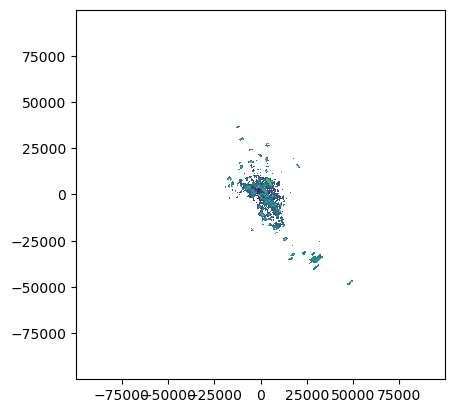

In [7]:
swp.DBZH.wrl.vis.plot()

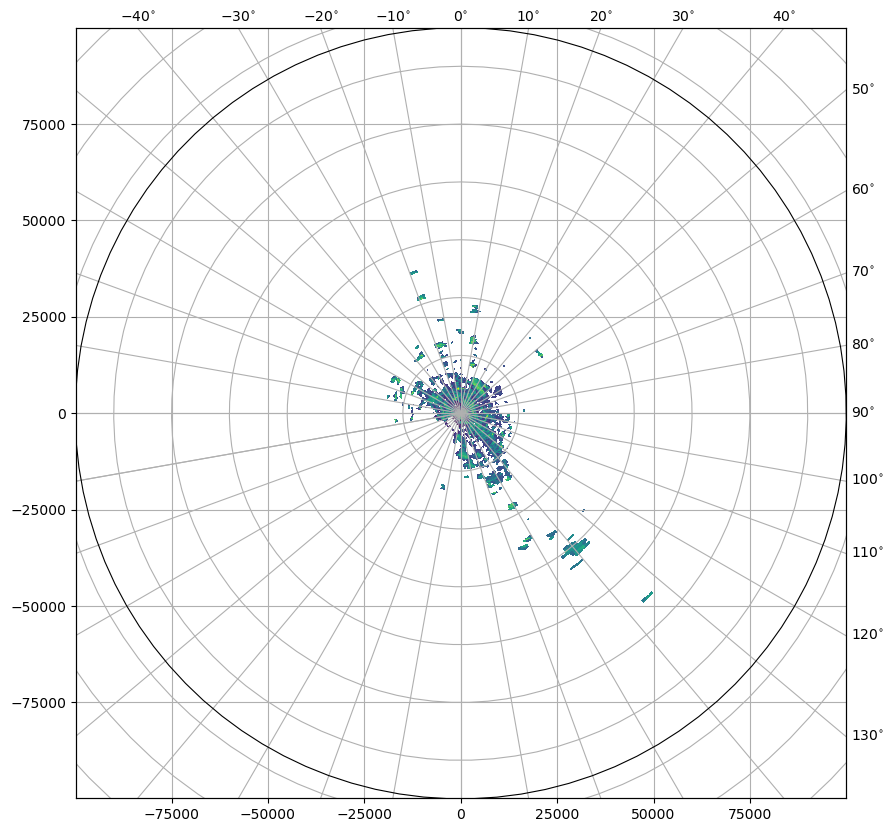

In [8]:
fig = plt.figure(figsize=(10, 10))
swp.DBZH.wrl.vis.plot(crs="cg", fig=fig)

In [9]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

map_trans = ccrs.AzimuthalEquidistant(
    central_latitude=swp.latitude.values, central_longitude=swp.longitude.values
)

< GeoAxes: +proj=aeqd +ellps=WGS84 +lon_0=6.379967 +lat_0=50.856633 +x_0=0.0 +y_0=0.0 +no_defs +type=crs >


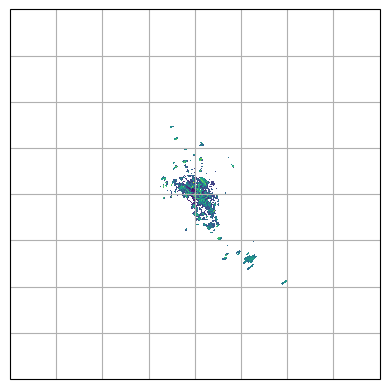

In [10]:
map_proj = ccrs.AzimuthalEquidistant(
    central_latitude=swp.latitude.values, central_longitude=swp.longitude.values
)
pm = swp.DBZH.wrl.vis.plot(crs=map_proj)
ax = plt.gca()
ax.gridlines(crs=map_proj)
print(ax)

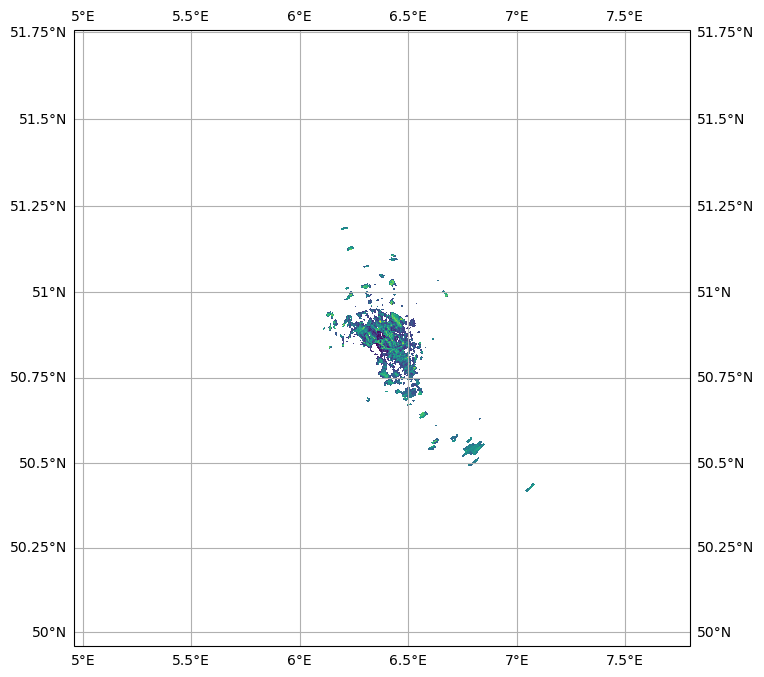

In [11]:
map_proj = ccrs.Mercator(central_longitude=swp.longitude.values)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=map_proj)
pm = swp.DBZH.wrl.vis.plot(ax=ax)
ax.gridlines(draw_labels=True)

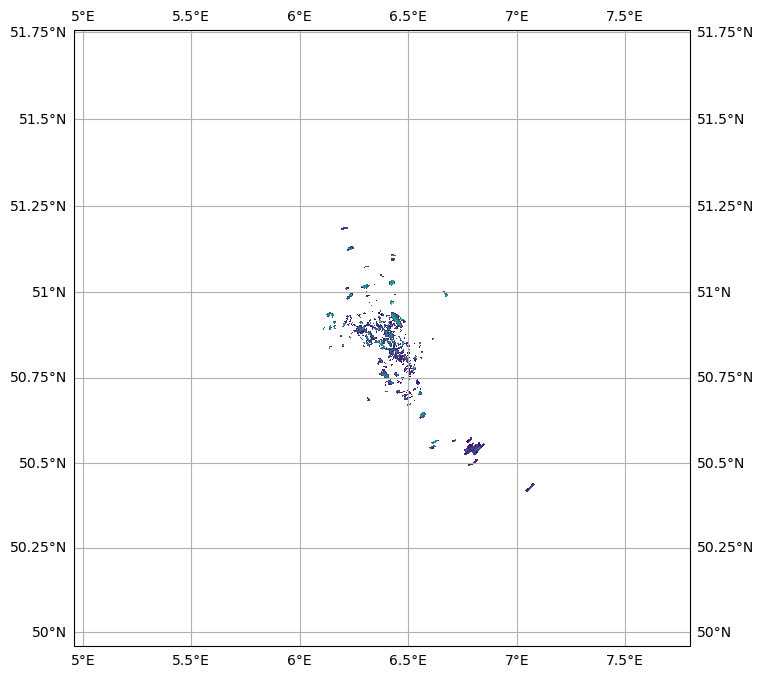

In [12]:
import cartopy.feature as cfeature


def plot_borders(ax):
    borders = cfeature.NaturalEarthFeature(
        category="physical", name="coastline", scale="10m", facecolor="none"
    )
    ax.add_feature(borders, edgecolor="black", lw=2, zorder=4)


map_proj = ccrs.Mercator(central_longitude=swp.longitude.values)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=map_proj)

DBZH = swp.DBZH
pm = DBZH.where(DBZH > 0).wrl.vis.plot(ax=ax)
plot_borders(ax)
ax.gridlines(draw_labels=True)

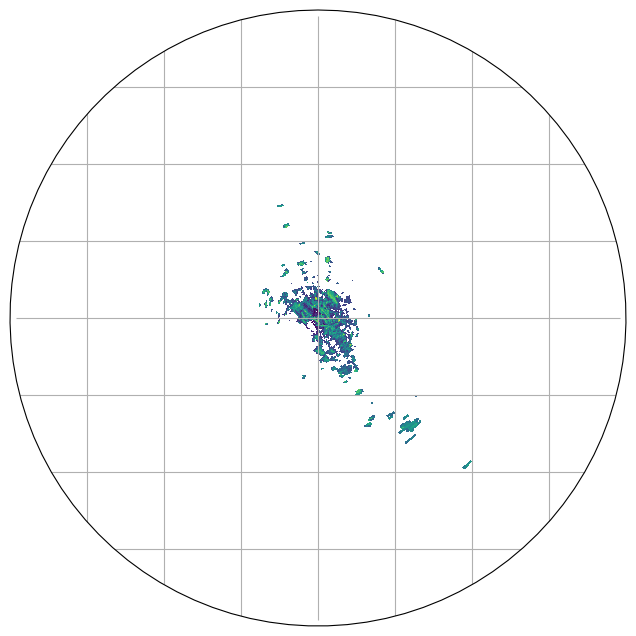

In [13]:
import matplotlib.path as mpath

theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

map_proj = ccrs.AzimuthalEquidistant(
    central_latitude=swp.latitude.values,
    central_longitude=swp.longitude.values,
)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=map_proj)
ax.set_boundary(circle, transform=ax.transAxes)

pm = swp.DBZH.wrl.vis.plot(crs=map_proj, ax=ax)
ax = plt.gca()
ax.gridlines(crs=map_proj)

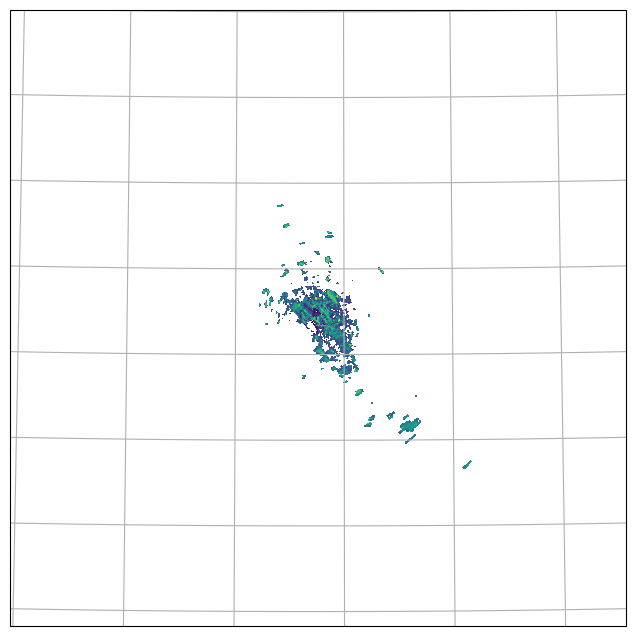

In [14]:
fig = plt.figure(figsize=(10, 8))
crs = ccrs.AzimuthalEquidistant(
    central_latitude=swp.latitude.values, central_longitude=swp.longitude.values
)
ax = fig.add_subplot(111, projection=crs)
pm = swp.DBZH.wrl.vis.plot(ax=ax)
ax.gridlines()

### Inspect radar moments

The DataArrays can be accessed by key or by attribute. Each DataArray has dimensions and coordinates of it's parent dataset.

In [15]:
display(swp.DBZH)

<xarray.DataArray 'DBZH' (azimuth: 361, range: 400)>
array([[24.5, 23. , 22. , ...,  nan,  nan,  nan],
       [24.5, 21. ,  1.5, ...,  nan,  nan,  nan],
       [25.5, 22.5,  0. , ...,  nan,  nan,  nan],
       ...,
       [24. , 29.5, -6.5, ...,  nan,  nan,  nan],
       [24. , 30. , -5.5, ...,  nan,  nan,  nan],
       [25.5, 29.5, -5.5, ...,  nan,  nan,  nan]], dtype=float32)
Coordinates: (12/15)
  * azimuth      (azimuth) float64 0.5055 1.549 2.505 ... 357.5 358.5 359.5
    elevation    (azimuth) float64 0.6 0.6 0.6 0.6 0.6 ... 0.6 0.6 0.6 0.6 0.6
  * range        (range) float32 125.0 375.0 625.0 ... 9.962e+04 9.988e+04
    time         (azimuth) datetime64[ns] 2013-05-10T00:00:15.500000 ... 2013...
    sweep_mode   <U20 'azimuth_surveillance'
    longitude    float64 6.38
    ...           ...
    y            (azimuth, range) float64 125.0 375.0 ... 9.96e+04 9.985e+04
    z            (azimuth, range) float64 118.0 120.6 ... 1.744e+03 1.75e+03
    gr           (azimuth, range) float64 124.8 374.7 ... 9.96e+04 9.985e+04
    rays         (azimuth, range) float64 0.5055 0.5055 0.5055 ... 359.5 359.5
    bins         (azimuth, range) float32 125.0 375.0 ... 9.962e+04 9.988e+04
    spatial_ref  int64 0
Attributes:
    long_name:      Equivalent reflectivity factor H
    standard_name:  radar_equivalent_reflectivity_factor_h
    units:          dBZ

### Create simple plot

Using xarray features a simple plot can be created like this. Note the `sortby('time')` method, which sorts the radials by time.

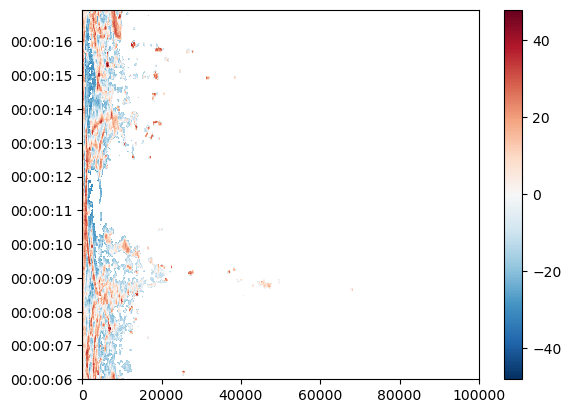

In [16]:
swp.DBZH.sortby("time").plot(x="range", y="time", add_labels=False)

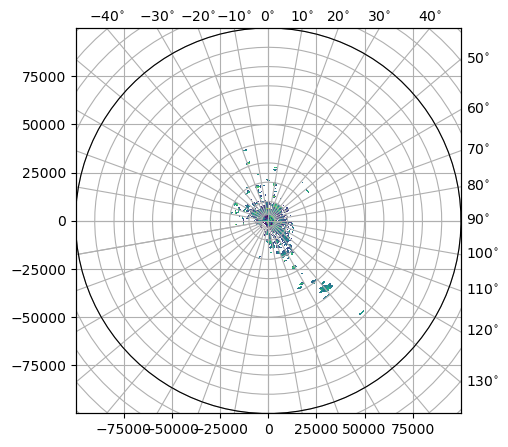

In [17]:
fig = plt.figure(figsize=(5, 5))
pm = swp.DBZH.wrl.vis.plot(crs={"latmin": 3e3}, fig=fig)

### Mask some values

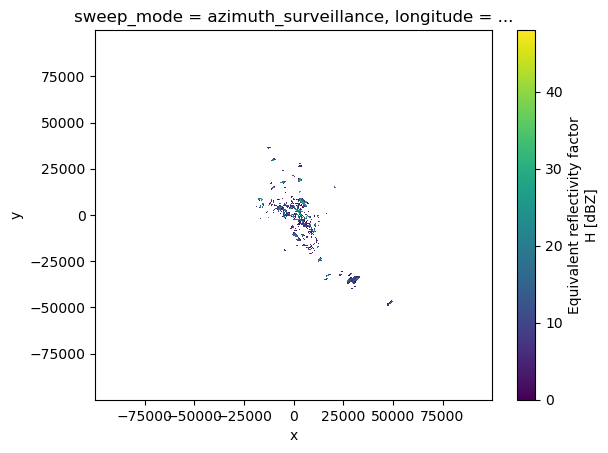

In [18]:
dbzh = swp["DBZH"].where(swp["DBZH"] >= 0)
dbzh.plot(x="x", y="y")

### Export to ODIM and CfRadial2

In [19]:
xd.io.to_odim(vol, "rainbow_as_odim.h5", source="RAD:WUE")
xd.io.to_cfradial2(vol, "rainbow_as_cfradial2.nc")

### Import again

In [20]:
vola = xd.io.open_odim_datatree("rainbow_as_odim.h5", reindex_angle=False)
display(vola)

DataTree('root', parent=None)
│   Dimensions:              ()
│   Data variables:
│       volume_number        int64 0
│       platform_type        <U5 'fixed'
│       instrument_type      <U5 'radar'
│       time_coverage_start  <U20 '2013-05-10T00:00:06Z'
│       time_coverage_end    <U20 '2013-05-10T00:03:14Z'
│       longitude            float64 6.38
│       altitude             float64 116.7
│       latitude             float64 50.86
│   Attributes:
│       Conventions:      ODIM_H5/V2_2
│       version:          None
│       title:            None
│       institution:      None
│       references:       None
│       source:           None
│       history:          None
│       comment:          im/exported using xradar
│       instrument_name:  None
├── DataTree('sweep_0')
│       Dimensions:            (azimuth: 361, range: 400)
│       Coordinates:
│         * azimuth            (azimuth) float32 0.4986 1.496 2.493 ... 358.5 359.5
│           elevation          (azimuth) float32 ...
│           time               (azimuth) datetime64[ns] 2013-05-10T00:00:15.552610816...
│         * range              (range) float32 125.0 375.0 625.0 ... 9.962e+04 9.988e+04
│           longitude          float64 ...
│           latitude           float64 ...
│           altitude           float64 ...
│       Data variables:
│           DBZH               (azimuth, range) float32 ...
│           sweep_mode         <U20 ...
│           sweep_number       int64 ...
│           prt_mode           <U7 ...
│           follow_mode        <U7 ...
│           sweep_fixed_angle  float64 ...
├── DataTree('sweep_1')
│       Dimensions:            (azimuth: 361, range: 400)
│       Coordinates:
│         * azimuth            (azimuth) float32 0.4986 1.496 2.493 ... 358.5 359.5
│           elevation          (azimuth) float32 ...
│           time               (azimuth) datetime64[ns] 2013-05-10T00:00:25.688351232...
│         * range              (range) float32 125.0 375.0 625.0 ... 9.962e+04 9.988e+04
│           longitude          float64 ...
│           latitude           float64 ...
│           altitude           float64 ...
│       Data variables:
│           DBZH               (azimuth, range) float32 ...
│           sweep_mode         <U20 ...
│           sweep_number       int64 ...
│           prt_mode           <U7 ...
│           follow_mode        <U7 ...
│           sweep_fixed_angle  float64 ...
├── DataTree('sweep_2')
│       Dimensions:            (azimuth: 361, range: 400)
│       Coordinates:
│         * azimuth            (azimuth) float32 0.4986 1.496 2.493 ... 358.5 359.5
│           elevation          (azimuth) float32 ...
│           time               (azimuth) datetime64[ns] 2013-05-10T00:00:36.702208 .....
│         * range              (range) float32 125.0 375.0 625.0 ... 9.962e+04 9.988e+04
│           longitude          float64 ...
│           latitude           float64 ...
│           altitude           float64 ...
│       Data variables:
│           DBZH               (azimuth, range) float32 ...
│           sweep_mode         <U20 ...
│           sweep_number       int64 ...
│           prt_mode           <U7 ...
│           follow_mode        <U7 ...
│           sweep_fixed_angle  float64 ...
├── DataTree('sweep_3')
│       Dimensions:            (azimuth: 361, range: 400)
│       Coordinates:
│         * azimuth            (azimuth) float32 0.4986 1.496 2.493 ... 358.5 359.5
│           elevation          (azimuth) float32 ...
│           time               (azimuth) datetime64[ns] 2013-05-10T00:00:46.807477504...
│         * range              (range) float32 125.0 375.0 625.0 ... 9.962e+04 9.988e+04
│           longitude          float64 ...
│           latitude           float64 ...
│           altitude           float64 ...
│       Data variables:
│           DBZH               (azimuth, range) float32 ...
│           sweep_mode         <U20 ...
│           sweep_number       int64 ...
│           prt_mode   

In [21]:
volb = xt.open_datatree("rainbow_as_cfradial2.nc")
display(volb)

DataTree('None', parent=None)
│   Dimensions:              ()
│   Data variables:
│       volume_number        int64 ...
│       platform_type        object ...
│       instrument_type      object ...
│       time_coverage_start  object ...
│       time_coverage_end    object ...
│       longitude            float64 ...
│       altitude             float64 ...
│       latitude             float64 ...
│   Attributes:
│       Conventions:      Cf/Radial
│       version:          2.0
│       title:            None
│       institution:      None
│       references:       None
│       source:           None
│       history:          None: xradar v0.3.0 CfRadial2 export
│       comment:          im/exported using xradar
│       instrument_name:  None
├── DataTree('sweep_0')
│       Dimensions:            (time: 361, range: 400)
│       Coordinates:
│         * range              (range) float32 125.0 375.0 625.0 ... 9.962e+04 9.988e+04
│         * time               (time) datetime64[ns] 2013-05-10T00:00:06.015151500 .....
│       Data variables:
│           DBZH               (time, range) float32 ...
│           azimuth            (time) float64 ...
│           elevation          (time) float64 ...
│           sweep_mode         object ...
│           sweep_number       int64 ...
│           prt_mode           object ...
│           follow_mode        object ...
│           sweep_fixed_angle  float64 ...
├── DataTree('sweep_1')
│       Dimensions:            (time: 361, range: 400)
│       Coordinates:
│         * range              (range) float32 125.0 375.0 625.0 ... 9.962e+04 9.988e+04
│         * time               (time) datetime64[ns] 2013-05-10T00:00:19.015151500 .....
│       Data variables:
│           DBZH               (time, range) float32 ...
│           azimuth            (time) float64 ...
│           elevation          (time) float64 ...
│           sweep_mode         object ...
│           sweep_number       int64 ...
│           prt_mode           object ...
│           follow_mode        object ...
│           sweep_fixed_angle  float64 ...
├── DataTree('sweep_2')
│       Dimensions:            (time: 361, range: 400)
│       Coordinates:
│         * range              (range) float32 125.0 375.0 625.0 ... 9.962e+04 9.988e+04
│         * time               (time) datetime64[ns] 2013-05-10T00:00:33.015151500 .....
│       Data variables:
│           DBZH               (time, range) float32 ...
│           azimuth            (time) float64 ...
│           elevation          (time) float64 ...
│           sweep_mode         object ...
│           sweep_number       int64 ...
│           prt_mode           object ...
│           follow_mode        object ...
│           sweep_fixed_angle  float64 ...
├── DataTree('sweep_3')
│       Dimensions:            (time: 361, range: 400)
│       Coordinates:
│         * range              (range) float32 125.0 375.0 625.0 ... 9.962e+04 9.988e+04
│         * time               (time) datetime64[ns] 2013-05-10T00:00:46.015151500 .....
│       Data variables:
│           DBZH               (time, range) float32 ...
│           azimuth            (time) float64 ...
│           elevation          (time) float64 ...
│           sweep_mode         object ...
│           sweep_number       int64 ...
│           prt_mode           object ...
│           follow_mode        object ...
│           sweep_fixed_angle  float64 ...
├── DataTree('sweep_4')
│       Dimensions:            (time: 361, range: 400)
│       Coordinates:
│         * range              (range) float32 125.0 375.0 625.0 ... 9.962e+04 9.988e+04
│         * time               (time) datetime64[ns] 2013-05-10T00:01:00.015151500 .....
│       Data variables:
│           DBZH               (time, range) float32 ...
│           azimuth            (time) float64 ...
│           elevation          (time) float64 ...
│           sweep_mode         object ...
│           sweep_number       int64 ...
│           prt_mode       

## More Rainbow5 loading mechanisms

### Use `xr.open_dataset` to retrieve explicit group

### use xradar-backend

In [22]:
swp_b = xr.open_dataset(
    f, engine="rainbow", group="sweep_5", backend_kwargs=dict(reindex_angle=False)
)
display(swp_b)

<xarray.Dataset>
Dimensions:            (azimuth: 361, range: 400)
Coordinates:
  * azimuth            (azimuth) float64 0.522 1.505 2.516 ... 357.5 358.5 359.5
    elevation          (azimuth) float64 ...
  * range              (range) float32 125.0 375.0 625.0 ... 9.962e+04 9.988e+04
    time               (azimuth) datetime64[ns] ...
    longitude          float64 ...
    latitude           float64 ...
    altitude           float64 ...
Data variables:
    DBZH               (azimuth, range) float32 ...
    sweep_mode         <U20 ...
    sweep_number       int64 ...
    prt_mode           <U7 ...
    follow_mode        <U7 ...
    sweep_fixed_angle  float64 ...